In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps
                                        
%matplotlib inline

In [2]:
from sklearn import datasets
import numpy as np
from statistics import mean
from scipy.special import softmax

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models, Model 
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization, Layer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.losses import categorical_crossentropy, mse
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import backend as K

In [4]:
X = np.asarray([[1.,0.], [-1.,0.], [0.,1.],[0.,-1.]]).astype('float32')

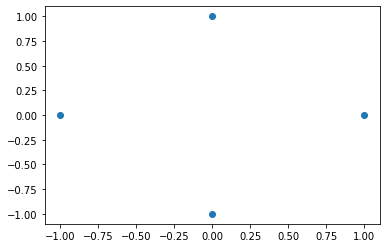

In [5]:
plt.scatter(X[:,0], X[:,1])

In [6]:
y=np.asarray([0.,1.,1.,0.]).astype('float32')

In [7]:
y_onehot = to_categorical(y)
y_onehot.shape
y_onehot

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [8]:
y_onehot = np.asarray([[1., 0.],
                       [0., 1.],
                       [0., 1.],
                       [1., 0.]])

In [41]:
K.clear_session()

In [42]:
batch_size = 4

In [43]:
input = input = layers.Input(shape=(2,), name='myInput')

In [44]:
#The selector layer that combines the expert and gate outputs. It is a non trainable layer
class selector_expectation(Layer):
    def __init__(self,num_experts, **kwargs):
        self.num_experts = num_experts
        super(selector_expectation,self).__init__(**kwargs)

    def build(self,input_shape):
        self.batch_size = input_shape[0]
        super(selector_expectation, self).build(input_shape)
        
    def call(self,input):

        x = input[0]
        p = input[1]
#         tf.print(self.batch_size, type(self.batch_size))
        tf.print('x:',x)
        tf.print(K.shape(x))
        tf.print('p:',p,'\n')
        x = K.reshape(x,(batch_size, self.num_experts, 2))
        tf.print(K.shape(x))
        tf.print(x)
        output =  K.sum(K.repeat_elements(K.reshape(p,(batch_size,self.num_experts,1)), rep=2,axis=2) * x, axis=1)
        tf.print('o:', output)
#         output = K.reshape(output, (1,2))
        return output
        
    def compute_output_shape(self,input_shape):
        return (input_shape[0],1,input_shape[-1])

    def get_config(self):
        return super(selector_expectation,self).get_config()


In [45]:
#Expert network
def expert_layers(input, name):
    exp_wts_mat = {'layer_0_wts': np.random.randn(2,X.shape[1]).astype("float32"),
                'layer_1_wts': np.random.randn(2,X.shape[1]).astype("float32"),}
    exp_bias_mat = {'layer_0_bias': np.random.randn(2,1),
                 'layer_1_bias': np.random.randn(2,1)}
    x = layers.Dense(2,activation='relu',
                    kernel_initializer=tf.constant_initializer(exp_wts_mat['layer_0_wts']), 
                     bias_initializer=tf.constant_initializer(exp_bias_mat['layer_0_bias']))(input)
    x = layers.Dense(2, activation='softmax',name=name,
                    kernel_initializer=tf.constant_initializer(exp_wts_mat['layer_1_wts']), 
                     bias_initializer=tf.constant_initializer(exp_bias_mat['layer_1_bias']))(x)
    return x, exp_wts_mat, exp_bias_mat

In [46]:
gate_wts_mat = {'layer_0_wts': np.random.randn(2,X.shape[1]).astype("float32"),
                'layer_1_wts': np.random.randn(2,X.shape[1]).astype("float32"),}
gate_bias_mat = {'layer_0_bias': np.random.randn(2,1),
                 'layer_1_bias': np.random.randn(2,1)}

In [47]:
#Gate network (Similar to the expert layer)
def gate_layers(input, name):    
    x = layers.Dense(2, activation='relu', 
                    kernel_initializer=tf.constant_initializer(gate_wts_mat['layer_0_wts']), 
                    bias_initializer=tf.constant_initializer(gate_bias_mat['layer_0_bias']))(input)
    x = layers.Dense(2,name=name,activation='softmax',
                     kernel_initializer=tf.constant_initializer(gate_wts_mat['layer_1_wts']), 
                     bias_initializer=tf.constant_initializer(gate_bias_mat['layer_1_bias']))(x)
    return x

In [48]:
# Custom Model to intercept training to analyze the gradients during training
class CustomModel(Model):
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            loss = self.compiled_loss(y, y_pred)
        
        trainable_vars = self.trainable_variables
        trainable_vars_names = []
        for var in trainable_vars:
            trainable_vars_names.append(var.name.split(':')[0])
        gradients = tape.gradient(loss, trainable_vars)
#         for i in range(len(gradients)):
#             tf.print(trainable_vars_names[i], ':', gradients[i],'\n')
        return super(CustomModel, self).train_step(data)

In [49]:
num_experts = 2

In [50]:
#Initialize gate network
gate = gate_layers(input, 'gate_layer')

In [51]:
#Initialize expert networks
experts = []
expert_wts = {}
expert_bias = {}
for i in range(num_experts):
    exp_layers, exp_wts_mat, exp_bias_mat = expert_layers(input, 'expert_'+str(i))
    experts.append(exp_layers)
    expert_wts['expert_'+str(i)] = exp_wts_mat
    expert_bias['expert_'+str(i)] = exp_bias_mat

In [52]:
# Initialize the selector network
expert_output = experts[0]
if num_experts > 1:
    expert_output = tf.keras.layers.Concatenate(axis=0)(experts)
selector_output = selector_expectation(num_experts=num_experts)([expert_output, gate])

In [53]:
selector_model = CustomModel(input, selector_output,name='selector')

In [54]:
selector_model.summary()

Model: "selector"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
myInput (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            6           myInput[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            6           myInput[0][0]                    
__________________________________________________________________________________________________
expert_0 (Dense)                (None, 2)            6           dense_1[0][0]                    
___________________________________________________________________________________________

In [55]:
def model_loss(actual, pred):
    loss = categorical_crossentropy(actual, pred)

In [56]:
selector_model.compile(optimizer='sgd', loss="categorical_crossentropy", metrics="accuracy")

In [ ]:
network_layer_outputs = {}

In [ ]:
# Computing output of expert 0

exp_outputs = {}

exp_wts_mat = expert_wts['expert_0'] 
exp_bias_mat = expert_bias['expert_0']

# layer 0 - ReLU
print('Expert 0 feed forward computation\n')
print('X', X[:1] )
exp_wts_mat_t = np.transpose(exp_wts_mat['layer_0_wts'])
print('W11:', exp_wts_mat_t[0])
print('b11:', exp_bias_mat['layer_0_bias'][0])
y1 = np.dot(X[:1], exp_wts_mat_t[0])+exp_bias_mat['layer_0_bias'][0]
print('y1:', y1)
exp_outputs['y1'] = y1
h11 = max([[0.], y1])
print('h11', h11)
exp_outputs['h11'] = h11
print('W12_t:', exp_wts_mat_t[1])
print('b12:', exp_bias_mat['layer_0_bias'][1])
y2 = np.dot(X[:1], exp_wts_mat_t[1])+exp_bias_mat['layer_0_bias'][1]
print('y2:', y2)
h12 =  max([[0.], y2])
print('h12',h12)
exp_outputs['h12'] = h12
X1 = np.asarray([h11, h12]).reshape((1,2))
print('layer 0 output or layer 1 input', X1, '\n')


# layer 1 - Softmax
print('X1', X1 )
exp_wts_mat_t = np.transpose(exp_wts_mat['layer_1_wts'])
print('W21:', exp_wts_mat_t[0])
print('b21:', exp_bias_mat['layer_1_bias'][0])
h21 = np.dot(X1, exp_wts_mat_t[0])+exp_bias_mat['layer_1_bias'][0]
print('h21', h21)
exp_outputs['h21'] = h21
print('W22_t:', exp_wts_mat_t[1])
print('b22:', exp_bias_mat['layer_1_bias'][1])
h22 =  np.dot(X1, exp_wts_mat_t[1])+exp_bias_mat['layer_1_bias'][1]
print('h22',h22)
exp_outputs['h22'] = h22
expert_1_output = softmax(np.concatenate((h21, h22)))
print('layer 1 output or Expert 1 output', expert_1_output)

network_layer_outputs['expert_0'] = exp_outputs

In [ ]:
print(X[:1])
print('Weights/Biases',selector_model.get_layer('dense_1').trainable_weights,'\n')
eo1 = selector_model.get_layer('dense_1')(X[:1])
print('dense_1:',eo1,'\n')
print('Weights/Biases',selector_model.get_layer('expert_0').trainable_weights, '\n')
eo1 = selector_model.get_layer('expert_0')(eo1)
print('expert_1_layer:', eo1,'\n')

In [ ]:
# Computing output of expert 2

exp_outputs = {}

exp_wts_mat = expert_wts['expert_1'] 
exp_bias_mat = expert_bias['expert_1']

# layer 0 - ReLU
print('Expert 2 feed forward computation\n')
print('X', X[:1] )
exp_wts_mat_t = np.transpose(exp_wts_mat['layer_0_wts'])
print('W11:', exp_wts_mat_t[0])
print('b11:', exp_bias_mat['layer_0_bias'][0])
y1 = np.dot(X[:1], exp_wts_mat_t[0])+exp_bias_mat['layer_0_bias'][0]
exp_outputs['y1'] = y1
h11 = max([[0.], y1])
exp_outputs['h11'] = h11
print('h11', h11,'\n')
print('W12:', exp_wts_mat_t[1])
print('b12:', exp_bias_mat['layer_0_bias'][1])
y2 = np.dot(X[:1], exp_wts_mat_t[1])+exp_bias_mat['layer_0_bias'][1]
exp_outputs['y2'] = y2
h12 =  max([[0.],y2])
exp_outputs['h12'] = h12
print('h12',h12)

X1 = np.concatenate((h11, h12)).reshape((1,2))
print('layer 0 output or layer 1 input', X1, '\n')

# layer 1 - Softmax
print('X1', X1 )
exp_wts_mat_t = np.transpose(exp_wts_mat['layer_1_wts'])
print('W21:', exp_wts_mat_t[0])
print('b21:', exp_bias_mat['layer_1_bias'][0])
h21 = np.dot(X1, exp_wts_mat_t[0])+exp_bias_mat['layer_1_bias'][0]
print('h21', h21,'\n' )
exp_outputs['h21'] = h21
print('W22:', exp_wts_mat_t[1])
print('b22:', exp_bias_mat['layer_1_bias'][1])
h22 =  np.dot(X1, exp_wts_mat_t[1])+exp_bias_mat['layer_1_bias'][1]
print('h22',h22)
exp_outputs['h22'] = h22

expert_2_output = softmax(np.concatenate((h21, h22)))
print('layer 2 output or Expert 2 output', expert_2_output)

network_layer_outputs['expert_1'] = exp_outputs

In [ ]:
print(X[:1])
print('Weights/Biases',selector_model.get_layer('dense_2').trainable_weights,'\n')
eo2 = selector_model.get_layer('dense_2')(X[:1])
print('dense_2:',eo2,'\n')
print('Weights/Biases',selector_model.get_layer('expert_1').trainable_weights, '\n')
eo2 = selector_model.get_layer('expert_1')(eo2)
print('expert_2_layer:', eo2,'\n')

In [ ]:
# Feed forward of gate network

# Computing output of gate

gate_outputs = {}

# layer 0 - ReLU
print('Gate feed forward computation\n')
print('X', X[:1] )
gate_wts_mat_t = np.transpose(gate_wts_mat['layer_0_wts'])
print('W11:', gate_wts_mat_t[0])
print('b11:', gate_bias_mat['layer_0_bias'][0])
y1 = np.dot(X[:1], gate_wts_mat_t[0])+gate_bias_mat['layer_0_bias'][0]
gate_outputs['y1'] = y1
h11 = max([[0.], y1])
print('h11', h11)
gate_outputs['h11'] = h11
print('W12:', gate_wts_mat_t[1])
print('b12:', gate_bias_mat['layer_0_bias'][1])
y2 = np.dot(X[:1], gate_wts_mat_t[1])+gate_bias_mat['layer_0_bias'][1]
gate_outputs['y2'] = y2
h12 =  max([[0.],y2])
print('h12',h12)
gate_outputs['h12'] = h12
X1 = np.concatenate((h11, h12)).reshape((1,2))
print('layer 0 output or layer 1 input', X1, '\n')


# layer 1 - Softmax
print('X1', X1 )
gate_wts_mat_t = np.transpose(gate_wts_mat['layer_1_wts'])
print('W21:', gate_wts_mat_t[0])
print('b21:', gate_bias_mat['layer_1_bias'][0])
h21 = np.dot(X1, gate_wts_mat_t[0])+gate_bias_mat['layer_1_bias'][0]
print('h21', h21)
gate_outputs['h21'] = h21
print('W22:', gate_wts_mat_t[1])
print('b22:', gate_bias_mat['layer_1_bias'][1])
h22 =  np.dot(X1, gate_wts_mat_t[1])+gate_bias_mat['layer_1_bias'][1]
print('h22',h22)
gate_outputs['h22'] = h22
print(np.concatenate((h21, h22)))
gate_output = softmax(np.concatenate((h21, h22)))
print('layer 1 output or Gate output', gate_output)

network_layer_outputs['gate'] = gate_outputs

In [ ]:
print(X[:1])
print(selector_model.get_layer('dense').trainable_weights)
go = selector_model.get_layer('dense')(X[:1])
print('dense_0:',go,'\n')
print('Weights/Biases',selector_model.get_layer('gate_layer').trainable_weights, '\n')
go = selector_model.get_layer('gate_layer')(go)
print('gate_layer:', go,'\n')

In [ ]:
# Expected output of experts using gate
sel_out = np.add(np.multiply(gate_output[0], expert_1_output), np.multiply(gate_output[1], expert_2_output))
sel_out

In [ ]:
# Expert 1 gradients
t1 = y_onehot[0,0]
t2 = y_onehot[0,1]

p1 = gate_output[0]
p2 = gate_output[1]
o11 = expert_1_output[0]
o12 = expert_1_output[1]

exp_outputs = network_layer_outputs['expert_1']
y1 = exp_outputs['y1']
y2 = exp_outputs['y2']
h11 = exp_outputs['h11']
h12 = exp_outputs['h12']
h21 = exp_outputs['h21']
h22 = exp_outputs['h22']

exp_wts_mat = expert_wts['expert_1'] 
exp_bias_mat = expert_bias['expert_1']

exp_wts_mat_t = np.transpose(exp_wts_mat['layer_0_wts'])
W11_0 = exp_wts_mat_t[0][0]
W11_1 = exp_wts_mat_t[0][1]
W12_0 = exp_wts_mat_t[1][0]
W12_1 = exp_wts_mat_t[1][1]

exp_wts_mat_t = np.transpose(exp_wts_mat['layer_1_wts'])
W21_0 = exp_wts_mat_t[0][0]
W21_1 = exp_wts_mat_t[0][1]
W22_0 = exp_wts_mat_t[1][0]
W22_1 = exp_wts_mat_t[1][1]

B11 = exp_bias_mat['layer_0_bias'][0]
B12 = exp_bias_mat['layer_0_bias'][1]
B21 = exp_bias_mat['layer_1_bias'][0]
B22 = exp_bias_mat['layer_1_bias'][1]


# o1 = p1*o11 + p2*o21
o1 = sel_out[0]
# o2 = p1*o12 + p2*o22
o2 = sel_out[1]

# cross entropy loss
# L = -t1 * log(o1) - t2 * log (o2)

# dL/do11 = dL/do1 * do1/do11 
# dL/do1 = -t1/o1
# do1/do11 = p1
dL_do11 = -1 * (t1/o1) * p1

# dL/do12 = dL/do2 * do2/do12
# dL/do2 = -t2/o2
# do2/do12 = p1
dL_do12 = -1. * (t2/o2) * p1

# gradients for expert_1 layer kernel

# h21 = h11*W21_0 + h12*W21_1 + B21
# do11/dW21_0 = do11/dh21 * dh21/dW21_0 
# do11/dh21 = o11(1-o11) derivative of softmax when i = j
# dh21/dW21_0 = h11
do11_dW21_0 = o11 * (1.-o11) * h11[0]

# do12/dW21_0 = do12/dh21 * dh21/dW21_0 
# do12/dh21 = -o11o12 derivative of softmax when i != j
# dh21/dW21_0 = h11
do12_dW21_0 = -1. * o11 * o12 * h11[0]

# dL/dW21_0 = dL/do11 * do11/dW21_0 + dL/do12 * do12/dW21_0
dL_dW21_0 = (dL_do11 * do11_dW21_0 )+ (dL_do12 * do12_dW21_0)

# h21 = h11*W21_0 + h12*W21_1 + b21
# do11/dW21_1 = do11/dh21 * dh21/dW21_1 
# do11/dh21 = o11(1-o11) derivative of softmax when i = j
# dh21/dW21_1 = h12
do11_dW21_1 = o11 * (1.-o11) * h12[0]

# do12/dW21_1 = do12/dh21 * dh21/dW21_1 
# do12/dh21 = -o11o12 derivative of softmax when i != j
# dh21/dW21_1 = h12
do12_dW21_1 = -1. * o11 * o12 * h12[0]

# dL/dW21_1 = dL/do11 * do11/dW21_1
dL_dW21_1= (dL_do11 * do11_dW21_1 )+ (dL_do12 * do12_dW21_1)

# h22 = h11*W22_0 + h12*W22_1 + b22
# do11/dW22_0 = do11/dh22 * dh22/dW22_0 
# do11/dh22 = -o11o12 derivative of softmax when i != j
# dh22/dW22_0 = h11
do11_dW22_0 = -1. *o11 * o12 * h11[0]

# do12/dW22_0 = do12/dh22 * dh22/dW22_0
# do12/dh22 = o12(1-o12) derivative of softmax when i = j
# dh22/dW22_0 = h11
do12_dW22_0 = o12 * (1.-o12) * h11[0]

# dL/dW22_0 = dL/do11 * do11/dW21_0 + dL/do12 * do12/dW22_0
dL_dW22_0 = (dL_do11 * do11_dW22_0 )+ (dL_do12 * do12_dW22_0)

# h22 = h11*W22_0 + h12*W22_1 + b22
# do11/dW22_1 = do11/dh22 * dh22/dW22_1 
# do11/dh22 = -o11o12 derivative of softmax when i != j
# dh22/dW22_1 = h12
do11_dW22_1 = -1. * o11 * o12 * h12[0]

# do12/dW22_1 = do12/dh22 * dh22/dW22_1 
# do12/dh22 = o12(1-o12) derivative of softmax when i == j
# dh22/dW22_1 = h12
do12_dW22_1 = o12 * (1.-o12) * h12[0]

# dL/dW21_1 = dL/do11 * do11/dW21_1 + dL_o12 * do12_dW22_1
dL_dW22_1= (dL_do11 * do11_dW22_1 )+ (dL_do12 * do12_dW22_1)

# gradients for expert 1 layer biases

# h21 = h11*W21_0 + h12*W21_1 + b21
# do11/dB21 = do11/dh21 * dh21/dB21 
# do11/dh21 = o11(1-o11) derivative of softmax when i = j
# dh21/dB21 = 1.
do11_dB21 = o11 * (1.-o11) * 1.

# do12/dB21 = do12/dh21 * dh21/dB21 
# do12/dh21 = -o11o12 derivative of softmax when i != j
# dh21/dB21 = 1.
do12_dB21 = -1. * o11 * o12 * 1.

# dL/dB21 = dL/dp1 * dp1/dB21 + dL/dp2 * dp2/dB21
dL_dB21 = (dL_do11 * do11_dB21 )+ (dL_do12 * do12_dB21)

# h22 = h11*W22_0 + h12*W22_1 + b22
# do11/dB22 = do11/dh22 * dh22/dB22 
# do11/dh22 = -o11o12 derivative of softmax when i != j
# dh22/dB22 = 1.
do11_dB22 = -1. * o11 * o12 * 1.

# do12/dB22 = do12/dh22 * dh22/dB22 
# do12/dh22 = o12(1-o12) derivative of softmax when i = j
# dh22/dB22 = 1.
do12_dB22 = o12 * (1.-o12) * 1.

# dL/dB22 = dL/dp1 * dp1/dB22 + dL/dp2 * dp2/dB22
dL_dB22 = (dL_do11 * do11_dB22 )+ (dL_do12 * do12_dB22)

# gradients for dense 2 layer weights

# h21 = h11*W21_0 + h12*W21_1 + b21
# h22 = h11*W22_0 + h12*W22_1 + b22
# do11/dh11 = do11/dh21 * dh21/dh11 + do11/dh22 * dh22/dh11
# do11/dh21 = o11(1-o11) derivative of softmax when i = j
# dh21/dh11 = W21_0
# do11/dh22 = -o11o12 derivative of softmax when i != j
# dh22/dh11 = W22_0
do11_dh11 = (o11 * (1.-o11) * W21_0) + (-1. * o11 * o12 * W22_0)

# do12/dh11 = do12/dh21 * dh21/dh11 + do12/dh22 * dh22/dh11
# do12/dh21 = -o11o12 derivative of softmax when i != j
# dh21/dh11 = W21_0
# do12/dh22 = o12(1-o12)
# dh22/dh11 = W22_0
do12_dh11 = (-1. * o11 * o12 * W21_0) + (o12 * (1.-o12) * W22_0)

# dL/dh11 = dL/dp1 * dp1/dh11 + dL/dp2 * dp2/dh11
dL_dh11 = (dL_do11 * do11_dh11 )+ (dL_do12 * do12_dh11)

# y1 = x1 * W11_0 + x2 * W11_1 +b11
# dh11/dW11_0 = dh11/dy1 * dy1/dW11_0
# dh11/dy1 = 0 if y1 < 0 and 1 if y1 > 0 derivative of relu
# dy1/dW11_0 = x1
dh11_dW11_0 = 0.
if y1 >= 0 :
    dh11_dW11_0 = 1.
dh11_dW11_0 = dh11_dW11_0 * X[0,0]

#dL/dW11_0 = dL/dh11 * dh11/dW11_0
dL_dW11_0 = dL_dh11 * dh11_dW11_0

# y1 = x1 * W11_0 + x2 * W11_1 +b11
# dh11/dW11_1 = dh11/dy1 * dy1/dW11_1
# dh11/dy1 = 0 if y1 < 0 and 1 if y1 >= 0 derivative of relu
# dy1/dW11_1 = x2
dh11_dW11_1 = 0.
if y1 >= 0 :
    dh11_dW11_1 = 1.
dh11_dW11_1 = dh11_dW11_1 * X[0,1]

#dL/dW11_0 = dL/dh11 * dh11/dW11_0
dL_dW11_1 = dL_dh11 * dh11_dW11_1

# h21 = h11*W21_0 + h12*W21_1 + b21
# h22 = h11*W22_0 + h12*W22_1 + b22
# do11/dh12 = do11/dh21 * dh21/dh12 + do11/dh22 * dh22/dh12
# do11/dh21 = o11(1-o11) derivative of softmax when i = j
# dh21/dh12 = W21_1
# do11/dh22 = -o11o12 derivative of softmax when i != j
# dh22/dh12 = W22_1
do11_dh12 = (o11 * (1.-o11) * W21_1) + (-1. * o11 * o12 * W22_1)

# do12/dh12 = do12/dh21 * dh21/dh12 + do12/dh22 * dh22/dh12
# do12/dh21 = -o11o12 derivative of softmax when i != j
# dh21/dh12 = W21_1
# do12/dh22 = o12(1-o12)
# dh22/dh12 = W22_1
do12_dh12 = (-1. * o11 * o12 * W21_1) + (o12 * (1.-o12) * W22_1)

# dL/dh12 = dL/dp1 * dp1/dh12 + dL/dp2 * dp2/dh12
dL_dh12 = (dL_do11 * do11_dh12 )+ (dL_do12 * do12_dh12)

# y2 = x1 * W12_0 + x2 * W12_1 +b12
# dh12/dW12_0 = dh12/dy2 * dy2/dW12_0
# dh12/dy2 = 0 if y2 < 0 and 1 if y2 >= 0 derivative of relu
# dy2/dW12_0 = x1
dh12_dW12_0 = 0.
if y2 >= 0 :
    dh12_dW12_0 = 1.
dh12_dW12_0 = dh12_dW12_0 * X[0,0]

#dL/dW12_0 = dL/dh12 * dh12/dW12_0
dL_dW12_0 = dL_dh12 * dh12_dW12_0

# y2 = x1 * W12_0 + x2 * W12_1 +b12
# dh12/dW12_1 = dh12/dy2 * dy2/dW12_1
# dh12/dy1 = 0 if y2 < 0 and 1 if y2 >= 0 derivative of relu
# dy2/dW12_1 = x2
dh12_dW12_1 = 0.
if y2 >= 0 :
    dh12_dW12_1 = 1.
dh12_dW12_1 = dh12_dW12_1 * X[0,1]

#dL/dW11_0 = dL/dh12 * dh11/dW11_0 
dL_dW12_1 = dL_dh12 * dh12_dW12_1

# gradients of dense 2 layer biases

# # y1 = x1 * W11_0 + x2 * W11_1 +b11
# # dh11/dB11 = dh11/dy1 * dy1/dB11
# # dh11/dy1 = 0 if h11 < 0 and 1 if h11 > 0 derivative of relu
# # dy1/dB11 = 1.
# dh11_dB11 = 0.
# if h11[0] > 0 :
#     dh11_dB11 = 1.
# dh11_dB11 = dh11_dB11 * 1.

# # y2 = x1 * W12_0 + x2 * W12_1 +b12
# # dh12/dB12 = dh12/dy2 * dy2/dB12
# # dh12/dy2 = 0 if h12 < 0 and 1 if h12 > 0 derivative of relu
# # dy2/dB12 = 1.
# dh12_dB12 = 0.
# if h12[0] > 0 :
#     dh12_dB12 = 1.
# dh12_dB12 = dh12_dB12 * 1.

# #dL/dB11 = dL/dp1 * dp1/dh11 * dh11/dB11 + dL/dp2 * dp2/dh11 * dh11/dB11
# dL_dB11 = (dL_dp1 * dp1_dh11 * dh11_dB11)  + (dL_dp2 * dp2_dh11 * dh11_dB11)

# #dL/dB12 = dL/dp1 * dp1/dh12 * dh12/dB12 + dL/dp2 * dp2/dh12 * dh12/dB12
# dL_dB12= (dL_dp1 * dp1_dh12 * dh12_dB12)  + (dL_dp2 * dp2_dh12 * dh12_dB12)

print('gradients for dense 2 layer kernel:\n [[', dL_dW11_0 , dL_dW12_0, '],[',dL_dW11_1 , dL_dW12_1,']]')
# # print('gradients for dense_layer bias:\n [', dL_dB11,dL_dB12, ']')

print('gradients for expert_1 kernel:\n [[', dL_dW21_0 , dL_dW22_0, '],[',dL_dW21_1 , dL_dW22_1,']]')
print('gradients for expert_1 layer bias:\n [', dL_dB21,dL_dB22, ']')


In [ ]:
dense_1/kernel : [[0.127086863 0.0918376222]
 [0 0]] 

dense_1/bias : [0.127086863 0.0918376222] 

dense_2/kernel : [[0.559607 1.46162128]
 [0 0]] 

dense_2/bias : [0.559607 1.46162128] 

expert_0/kernel : [[-0.262972623 0.262972593]
 [-0.0538177267 0.0538177229]] 

expert_0/bias : [-0.123351485 0.12335147] 

expert_1/kernel : [[-0.865493059 0.865493119]
 [-0.99379164 0.993791699]] 

expert_1/bias : [-0.717874348 0.717874408] 


In [ ]:
# Gate gradients
t1 = y_onehot[0,0]
t2 = y_onehot[0,1]

p1 = gate_output[0]
p2 = gate_output[1]
o11 = expert_1_output[0]
o12 = expert_1_output[1]
o21 = expert_2_output[0]
o22 = expert_2_output[1]

gate_wts_mat_t = np.transpose(gate_wts_mat['layer_0_wts'])
W11_0 = gate_wts_mat_t[0][0]
W11_1 = gate_wts_mat_t[0][1]
W12_0 = gate_wts_mat_t[1][0]
W12_1 = gate_wts_mat_t[1][1]

gate_wts_mat_t = np.transpose(gate_wts_mat['layer_1_wts'])
W21_0 = gate_wts_mat_t[0][0]
W21_1 = gate_wts_mat_t[0][1]
W22_0 = gate_wts_mat_t[1][0]
W22_1 = gate_wts_mat_t[1][1]

B11 = gate_bias_mat['layer_0_bias'][0]
B12 = gate_bias_mat['layer_0_bias'][1]
B21 = gate_bias_mat['layer_1_bias'][0]
B12 = gate_bias_mat['layer_1_bias'][1]

gate_outputs = network_layer_outputs['gate']
y1 = gate_outputs['y1']
y2 = gate_outputs['y2']
h11 = gate_outputs['h11']
h12 = gate_outputs['h12']
h21 = gate_outputs['h21']
h22 = gate_outputs['h22']

# o1 = p1*o11 + p2*o21
o1 = sel_out[0]
# o2 = p1*o12 + p2*o22
o2 = sel_out[1]

# cross entropy loss
# L = -t1 * log(o1) - t2 * log (o2)
# dL/dp1 = dL/do1 * do1/dp1 + dL/do2 * do2/dp1
# dL/do1 = -t1/o1
# do1/dp1 = o11
# dL/do2 = -t2/o2
# do2/dp1 = o12
dL_dp1 = (-1. * (t1/o1) * o11) + (-1. * (t2/o2) * o12)
# dL/dp2 = dL/do1 * do1/dp2 + dL/do2 * do2/dp2
# dL/do1 = -t1/o1
# do1/dp2 = o21
# dL/do2 = -t2/o2
# do2/dp2 = o22
dL_dp2 = (-1. * (t1/o1) * o21) + (-1. * (t2/o2) * o22)

# gradients for gate_layer weights

# h21 = h11*W21_0 + h12*W21_1 + b21
# dp1/dW21_0 = dp1/dh21 * dh21/dW21_0 
# dp1/dh21 = p1(1-p1) derivative of softmax when i = j
# dh21/dW21_0 = h11
dp1_dW21_0 = p1 * (1.-p1) * h11[0]

# dp2/dW21_0 = dp2/dh21 * dh21/dW21_0 
# dp2/dh21 = -p1p2 derivative of softmax when i != j
# dh21/dW21_0 = h11
dp2_dW21_0 = -1. * p1 * p2 * h11[0]

# dL/dW21_0 = dL/dp1 * dp1/dW21_0 + dL/dp2 * dp2/dW21_0
dL_dW21_0 = (dL_dp1 * dp1_dW21_0 )+ (dL_dp2 * dp2_dW21_0)

# h21 = h11*W21_0 + h12*W21_1 + b21
# dp1/dW21_1 = dp1/dh21 * dh21/dW21_1 
# dp1/dh21 = p1(1-p1) derivative of softmax when i = j
# dh21/dW21_1 = h12
dp1_dW21_1 = p1 * (1.-p1) * h12[0]

# dp2/dW21_1 = dp2/dh21 * dh21/dW21_1 
# dp2/dh21 = -p1p2 derivative of softmax when i != j
# dh21/dW21_1 = h12
dp2_dW21_1 = -1. * p1 * p2 * h12[0]

# dL/dW21_1 = dL/dp1 * dp1/dW21_1
dL_dW21_1= (dL_dp1 * dp1_dW21_1 )+ (dL_dp2 * dp2_dW21_1)

# h22 = h11*W22_0 + h12*W22_1 + b22
# dp1/dW22_0 = dp1/dh22 * dh22/dW22_0 
# dp1/dh22 = -p1p2 derivative of softmax when i != j
# dh22/dW22_0 = h11
dp1_dW22_0 = -1. *p1 * p2 * h11[0]

# dp2/dW22_0 = dp2/dh22 * dh22/dW22_0
# dp2/dh22 = p1(1-p1) derivative of softmax when i = j
# dh22/dW22_0 = h11
dp2_dW22_0 = p1 * (1.-p1) * h11[0]

# dL/dW21_0 = dL/dp1 * dp1/dW21_0
dL_dW22_0 = (dL_dp1 * dp1_dW22_0 )+ (dL_dp2 * dp2_dW22_0)

# h22 = h11*W22_0 + h12*W22_1 + b22
# dp1/dW22_1 = dp1/dh22 * dh22/dW22_1 
# dp1/dh22 = -p1p2 derivative of softmax when i != j
# dh22/dW22_1 = h12
dp1_dW22_1 = -1. * p1 * p2 * h12[0]

# dp2/dW22_1 = dp2/dh22 * dh22/dW22_1 
# dp2/dh22 = p1(1-p1) derivative of softmax when i == j
# dh22/dW22_1 = h12
dp2_dW22_1 = p1 * (1.-p1) * h12[0]

# dL/dW21_1 = dL/dp1 * dp1/dW21_1
dL_dW22_1= (dL_dp1 * dp1_dW22_1 )+ (dL_dp2 * dp2_dW22_1)

# gradients for gate_layer biases

# h21 = h11*W21_0 + h12*W21_1 + b21
# dp1/dB21 = dp1/dh21 * dh21/dB21 
# dp1/dh21 = p1(1-p1) derivative of softmax when i = j
# dh21/dB21 = 1.
dp1_dB21 = p1 * (1.-p1) * 1.

# dp2/dB21 = dp2/dh21 * dh21/dB21 
# dp2/dh21 = -p1p2 derivative of softmax when i != j
# dh21/dB21 = 1.
dp2_dB21 = -1. * p1 * p2 * 1.

# dL/dB21 = dL/dp1 * dp1/dB21 + dL/dp2 * dp2/dB21
dL_dB21 = (dL_dp1 * dp1_dB21 )+ (dL_dp2 * dp2_dB21)

# h22 = h11*W22_0 + h12*W22_1 + b22
# dp1/dB22 = dp1/dh22 * dh22/dB22 
# dp1/dh22 = -p1p2 derivative of softmax when i != j
# dh22/dB22 = 1.
dp1_dB22 = -1. * p1 * p2 * 1.

# dp2/dB22 = dp2/dh22 * dh22/dB22 
# dp2/dh22 = p2(1-p2) derivative of softmax when i = j
# dh22/dB22 = 1.
dp2_dB22 = p2 * (1.-p2) * 1.

# dL/dB22 = dL/dp1 * dp1/dB22 + dL/dp2 * dp2/dB22
dL_dB22 = (dL_dp1 * dp1_dB22 )+ (dL_dp2 * dp2_dB22)

# gradients for dense layer kernel

# h21 = h11*W21_0 + h12*W21_1 + b21
# h22 = h11*W22_0 + h12*W22_1 + b22
# dp1/dh11 = dp1/dh21 * dh21/dh11 + dp1/dh22 * dh22/dh11
# dp1/dh21 = p1(1-p1) derivative of softmax when i = j
# dh21/dh11 = W21_0
# dp1/dh22 = -p1p2 derivative of softmax when i != j
# dh22/dh11 = W22_0
dp1_dh11 = (p1 * (1.-p1) * W21_0) + (-1. * p1 * p2 * W22_0)

# dp2/dh11 = dp2/dh21 * dh21/dh11 + dp2/dh22 * dh22/dh11
# dp2/dh21 = -p1p2 derivative of softmax when i != j
# dh21/dh11 = W21_0
# dp2/dh22 = p2(1-p2)
# dh22/dh11 = W22_0
dp2_dh11 = (-1. * p1 * p2 * W21_0) + (p2 * (1.-p2) * W22_0)

# dL/dh11 = dL/dp1 * dp1/dh11 + dL/dp2 * dp2/dh11
dL_dh11 = (dL_dp1 * dp1_dh11 )+ (dL_dp2 * dp2_dh11)

# y1 = x1 * W11_0 + x2 * W11_1 +b11
y1 = X[0,0] * W11_0 + X[0,1] * W11_1 + B11
# dh11/dW11_0 = dh11/dy1 * dy1/dW11_0
# dh11/dy1 = 0 if y1 < 0 and 1 if y1 > 0 derivative of relu
# dy1/dW11_0 = x1
dh11_dW11_0 = 0.
if y1 >= 0 :
    dh11_dW11_0 = 1.
dh11_dW11_0 = dh11_dW11_0 * X[0,0]

#dL/dW11_0 = dL/dh11 * dh11/dW11_0 
dL_dW11_0 = (dL_dh11 * dh11_dW11_0)

# y1 = x1 * W11_0 + x2 * W11_1 +b11
# dh11/dW11_1 = dh11/dy1 * dy1/dW11_1
# dh11/dy1 = 0 if h11 < 0 and 1 if h11 > 0 derivative of relu
# dy1/dW11_1 = x2
dh11_dW11_1 = 0.
if y1 >= 0 :
    dh11_dW11_1 = 1.
dh11_dW11_1 = dh11_dW11_1 * X[0,1]

#dL/dW11_0 = dL/dh11 * dh11/dW11_0 + dL/dh11 * dh11/dW11_0
dL_dW11_1 = dL_dh11 * dh11_dW11_1

# h21 = h11*W21_0 + h12*W21_1 + b21
# h22 = h11*W22_0 + h12*W22_1 + b22
# dp1/dh12 = dp1/dh21 * dh21/dh12 + dp1/dh22 * dh22/dh12
# dp1/dh21 = p1(1-p1) derivative of softmax when i = j
# dh21/dh12 = W21_1
# dp1/dh22 = -p1p2 derivative of softmax when i != j
# dh22/dh12 = W22_1
dp1_dh12 = (p1 * (1.-p1) * W21_1) + (-1. * p1 * p2 * W22_1)

# dp2/dh12 = dp2/dh21 * dh21/dh12 + dp2/dh22 * dh22/dh12
# dp2/dh21 = -p1p2 derivative of softmax when i != j
# dh21/dh12 = W21_1
# dp2/dh22 = p2(1-p2)
# dh22/dh12 = W22_1
dp2_dh12 = (-1. * p1 * p2 * W21_1) + (p2 * (1.-p2) * W22_1)

# dL/dh12 = dL/dp1 * dp1/dh12 + dL/dp2 * dp2/dh12
dL_dh12 = (dL_dp1 * dp1_dh12 )+ (dL_dp2 * dp2_dh12)

# y2 = x1 * W12_0 + x2 * W12_1 +b12
y2 = X[0,0] * W12_0 + X[0,1] * W12_1
# dh12/dW12_0 = dh12/dy2 * dy2/dW12_0
# dh12/dy2 = 0 if y2 < 0 and 1 if y2 >= 0 derivative of relu
# dy2/dW12_0 = x1
dh12_dW12_0 = 0.
if y2 >= 0 :
    dh12_dW12_0 = 1.
dh12_dW12_0 = dh12_dW12_0 * X[0,0]

#dL/dW12_0 = dL/dh12 * dh12/dW12_0
dL_dW12_0 = dL_dh12 * dh12_dW12_0

# y2 = x1 * W12_0 + x2 * W12_1 +b12
# dh12/dW12_1 = dh12/dy2 * dy2/dW12_1
# dh12/dy2 = 0 if y2 < 0 and 1 if y2 >= 0 derivative of relu
# dy2/dW12_1 = x2
dh12_dW12_1 = 0.
if y2 >= 0 :
    dh12_dW12_1 = 1.
dh12_dW12_1 = dh12_dW12_1 * X[0,1]

#dL/dW12_1= dL/dh12 * dh12/dW11_1 
dL_dW12_1 = dL_dh12 * dh12_dW12_1

# y1 = x1 * W11_0 + x2 * W11_1 +b11
# dh11/dB11 = dh11/dy1 * dy1/dB11
# dh11/dy1 = 0 if y1 < 0 and 1 if y1>=  0 derivative of relu
# dy1/dB11 = 1.
dh11_dB11 = 0.
if y1 >= 0 :
    dh11_dB11 = 1.
dh11_dB11 = dh11_dB11 * 1.

# y2 = x1 * W12_0 + x2 * W12_1 +b12
# dh12/dB12 = dh12/dy2 * dy2/dB12
# dh12/dy2 = 0 if y2 < 0 and 1 if y2 >= 0 derivative of relu
# dy2/dB12 = 1.
dh12_dB12 = 0.
if y2 >= 0 :
    dh12_dB12 = 1.
dh12_dB12 = dh12_dB12 * 1.

#dL/dB11 = dL/dh11 * dh11/dB11 
dL_dB11 = dL_dh11 * dh11_dB11 

#dL/dB12 = dL/dh12 * dh12/dB12 + dL/dh12 * dh12/dB12
dL_dB12= dL_dh12 * dh12_dB12

print('gradients for dense layer kernel:\n [[', dL_dW11_0 , dL_dW12_0, '],[',dL_dW11_1 , dL_dW12_1,']]')
print('gradients for dense_layer bias:\n [', dL_dB11,dL_dB12, ']')

print('gradients for gate_layer kernel:\n [[', dL_dW21_0 , dL_dW22_0, '],[',dL_dW21_1 , dL_dW22_1,']]')
print('gradients for gate_layer bias:\n [', dL_dB21,dL_dB22, ']')

gate_gradients = {'dense layer kernel':[[ dL_dW11_0 , dL_dW12_0],[dL_dW11_1 , dL_dW12_1]],
                  'dense layer bias':[dL_dB11,dL_dB12]}

In [ ]:
#cross entropy loss
actual = y_onehot[:1][0]
pred = sel_out
print('actual:', actual)
print('pred:', pred)
print(np.subtract(actual,pred))
# loss = np.mean(np.square(np.subtract(actual,pred)))
loss = 0.0
for i in range(actual.shape[0]):
    loss += -1 * (actual[i]*np.log(pred[i]))
print('loss:', loss)
print('loss:',categorical_crossentropy(actual, pred))

In [57]:
selector_model.fit(X, y_onehot, epochs=5, batch_size=batch_size, shuffle=True)

Epoch 1/5
x: [[0.192768693 0.807231307]
 [0.768282533 0.231717497]
 [0.351032 0.648968]
 ...
 [0.586429536 0.413570464]
 [0.626053393 0.373946697]
 [0.586429536 0.413570464]]
[8 2]
p: [[0.777836144 0.222163916]
 [0.303484738 0.696515322]
 [0.489089429 0.51091063]
 [0.777836144 0.222163916]] 

[4 2 2]
[[[0.192768693 0.807231307]
  [0.768282533 0.231717497]]

 [[0.351032 0.648968]
  [0.564717 0.435282946]]

 [[0.586429536 0.413570464]
  [0.586429536 0.413570464]]

 [[0.626053393 0.373946697]
  [0.586429536 0.413570464]]]
o: [[0.320627093 0.679372966]
 [0.499866873 0.500133097]
 [0.586429596 0.413570464]
 [0.617250443 0.382749707]]
x: [[0.192768693 0.807231307]
 [0.768282533 0.231717497]
 [0.351032 0.648968]
 ...
 [0.586429536 0.413570464]
 [0.626053393 0.373946697]
 [0.586429536 0.413570464]]
[8 2]
p: [[0.777836144 0.222163916]
 [0.303484738 0.696515322]
 [0.489089429 0.51091063]
 [0.777836144 0.222163916]] 

[4 2 2]
[[[0.192768693 0.807231307]
  [0.768282533 0.231717497]]

 [[0.351032 0

In [ ]:
gradients for expert_1 kernel:
 [[ -0.14871660664237052 0.1487166066423705 ],[ -0.1707620017944827 0.17076200179448267 ]]
gradients for exp_layer bias:
 [ -0.12335146791948583 0.1233514679194858 ]

In [ ]:
print(expert_1_output)
print(expert_2_output)
print(gate_output)
print(loss)